## NCX mice model

This is the initiation of key variables in the program. 
- ```no``` and ```ni``` =extracellular an cytopalsmic Na concentrations
- ```co``` and ```ci``` = free extra and intracellular Ca concentrations
- ```ko``` and ```ki``` = extra and intracellular K concentrations
- ```casr``` =ca concentration of SR
- ```citot``` =total ca concentration of cytoplasm

Concentrations are in mM and the SR volume is assumed to be functionally 10x less than the cytoplasm volume.SR Ca is treated as if it is free in this overly large assumed SR volume  

The simulation repeats an ECC cycle of 200 ms 3000 times so the heart is
 beating at 5 Hz
 
- For total simplicity I am simulating here without using a proper
integrator.
- This way you can just see the code for the equations.
- The stepsize is so small (1 microsecond) the the simulation is accurate without using a complex integrator. 
- Time is being calculated in milliseconds.
- Em is calculated as a charge imbalance in the cytoplasm....I just increase cytoplasmic Na by 4 micromolar to trigger an action potential
- After 320 cycles I reduce extracellular Na to 70 mM and then after 1000 cycles increase back to 150 mM.

In [1]:
import numpy as np
from scipy import linalg
from scipy.integrate import odeint

#### Parameters

In [2]:
no = 150; ni = 5.2
ko = 5; ki = 145
co = 2; ci = 0.0001
citot = ci*40
casr = 3.3
count = 0
dt = 0.001; em = -90
fr = 1; fo = 0
foc = 0; frc = 1
t = 0
fdk1 = 0
fdk2 = 0
fdk3 = 0
fsrinact = 0.5
hh = 0
anion=ni+ki+(2*citot)+(2*casr/10)

#### Run time variables

```Data```is a blank lsit to hold data dictionaries. In each loop of the simulation, a data dictionary is pepread and added to this list. A sample of data dictionary looks as shown below.

```
{'ninow':ni,'fdknow':fdk2,\
'emout':em,'inaout':ina,\
'foout':fo,'frout':fr,\
'icanow':ica,'incxnow':incx,\
'casrnow':casr,'cinow':ci,'tout':t/1000}
```
This list of dictionaries is used to creat data frame using ```Pandas``` library in python. Data frame is very convenient for data analysis and plotting.

In [3]:
Data =[]
REP = 3000
I = 200000

#### Log file to debug errors

This file collects the data as we run the code for simulation.We can stop collecting this data by setting ```is_print = False```.

#### Simulations

In [4]:
for rep in range(1,REP+1):
    pt = True
    for i in range(1,I+1):
        if i==80000:
            ni=ni+0.004
        if rep>320:
            no=70
        if rep>1000:
            no=150
        t = t+dt
        
        if rep%100 == 0 and pt:
            print(rep, "steps in REP done!")
            pt = False
            
            
        k1= 0.025*np.exp((em+90)/12.0)  
        fo= fo + ( (fr*k1) - (fo*(0.5+(0.25/k1))) )*dt
        fr= fr + ( (1-fr)*(0.15/k1)-(fr*k1) )*dt 
        if em==0:
            em=0.001
        kem1 = np.exp(em/26.0)
        ina  = (-600*fo**2)*em*(no-(ni*kem1))/((100+no+ni)*(kem1-1.0)) 
        kca  = 0.025*np.exp((em+60)/12.0)                             
        foc  = foc + ( (frc*kca) - (foc*(0.5+(0.25/kca))) )*dt
        frc  = frc + ( (1-frc)*(0.15/kca) - (fr*kca) )*dt 
        ica = -900*(fo**2)*em*(co-ci*kem1**2)/((100+co+ci)*(kem1**2-1.0))
        firk= 1/(1+np.exp((em+60)/15)) 
        kedk= np.exp((em+42)/10)                                     
        fdk1= fdk1 + (((1-fdk1-fdk2-fdk3)*kedk) + (fdk2/kedk) -\
                      (fdk1*(kedk+(15/kedk))))*0.0003*dt
        fdk2= fdk2 + ((fdk1*kedk) - (15*fdk2/kedk))*0.0003*dt
        fdk3= fdk3 + ((fdk2*kedk) - (15*fdk3/kedk))*0.0003*dt
        ik =-((250*firk) + (fdk3*220))*em*((ko-(ki*kem1))/((50+ko+ki)*(kem1-1.0)))  
        ipump=((ni**3)/((ni**3)+(20**3)))*(6*200)      
        dout=1+(co/0.01)+((no/20)*(1+(no/20.0)))                            
        din= 1+(ci/0.01)+((ni/20)*(1+(ni/20.0)))
        fco=(co/0.01)/dout
        f2no=no*no/(20*20*dout)
        fci=ci/(0.01*din)
        f2ni=ni*ni/(20*20*din)
        f3ni=f2ni*ni/(ni+30)
        f3no=f2no*no/(no+30)
        kem=np.exp(em/55.0) 
        incx=80*(fco*f3ni*kem-fci*f3no/kem)/(fco+f3ni*kem+fci+f3no/kem)
        fcain=ci/(ci+0.002)                                             
        fcasr=casr/(casr+2)
        frel=-ica/(-ica+100)
        fsrinact= fsrinact+((1-fsrinact)*frel*(2-(fsrinact*0.005)))*dt
        dcasr= ((0.015*fcain)-(0.002*fcasr))- (frel*(1-fsrinact)*casr*0.13)
        casr= casr+(dcasr*10)*dt
        ni=ni-(ina+(ipump*3)+(incx*3))*1e-6*dt   
        ki=ki-(ik-(ipump*2))*1e-6*dt                               
        citot=citot-((((ica/2)-incx)*1e-6) + dcasr)*dt                  
        ci=citot/40
        #anion=ni+ki+2*citot+2*casr/10
        
        em=(ni+ki+2*citot+2*casr/10-anion)*12000
    
        count=count+1 
        if count>50:                                                
            count=0
            Data.append({'ninow':ni,'fdknow':fdk2,'emout':em,'inaout':ina,\
                         'foout':fo,'frout':fr,'icanow':ica,'incxnow':incx,\
                         'casrnow':casr,'cinow':ci,'tout':t/1000})

100 steps in REP done!
200 steps in REP done!
300 steps in REP done!
400 steps in REP done!
500 steps in REP done!
600 steps in REP done!
700 steps in REP done!
800 steps in REP done!
900 steps in REP done!
1000 steps in REP done!
1100 steps in REP done!
1200 steps in REP done!
1300 steps in REP done!
1400 steps in REP done!
1500 steps in REP done!
1600 steps in REP done!
1700 steps in REP done!
1800 steps in REP done!
1900 steps in REP done!
2000 steps in REP done!
2100 steps in REP done!
2200 steps in REP done!
2300 steps in REP done!
2400 steps in REP done!
2500 steps in REP done!
2600 steps in REP done!
2700 steps in REP done!
2800 steps in REP done!
2900 steps in REP done!
3000 steps in REP done!


#### Data frame

In [5]:
import pandas as pd

In [6]:
DF = pd.DataFrame(Data)
DF.head(10)

,casrnow,cinow,emout,fdknow,foout,frout,icanow,inaout,incxnow,ninow,tout
0,3.254008,0.000215,2.296742,5.933752e-07,0.899989,8.492204e-02,-170.425216,-6846.657046,0.265749,5.200188,0.000051
1,3.191738,0.000371,6.772618,3.651863e-06,0.958088,2.620327e-03,-160.995978,-7049.782473,0.170336,5.200554,0.000102
2,3.138613,0.000504,10.845098,1.342697e-05,0.936452,2.990385e-05,-129.144573,-6149.556177,0.115519,5.200886,0.000153
3,3.094093,0.000615,14.392333,3.869019e-05,0.912859,7.233672e-06,-104.698853,-5383.368085,0.087084,5.201176,0.000204
4,3.056703,0.000709,17.504661,9.544698e-05,0.889851,4.182401e-06,-86.120489,-4749.236431,0.075931,5.201431,0.000255
5,3.025202,0.000787,20.255482,2.103618e-04,0.867426,2.602082e-06,-71.765389,-4218.118599,0.076181,5.201656,0.000306
6,2.998574,0.000854,22.702313,4.245901e-04,0.845570,1.713194e-06,-60.500734,-3768.501507,0.083953,5.201855,0.000357
7,2.975988,0.000911,24.890892,7.976486e-04,0.824267,1.181623e-06,-51.535028,-3384.276017,0.096643,5.202034,0.000408
8,2.956766,0.000959,26.858065,1.410857e-03,0.803502,8.474057e-07,-44.306071,-3053.178883,0.112480,5.202195,0.000459
9,2.940355,0.001000,28.633864,2.369851e-03,0.783261,6.282608e-07,-38.408163,-2765.734958,0.130249,5.202340,0.000510


In [7]:
DF.to_csv("data.csv")

In [8]:
#data = pd.read_csv("data.csv")
#data.shape

In [9]:
DF.shape

(11764705, 11)

#### Plotting

We can use Dataframe ```DF``` created above for creating plots. Each column of dataframe are single variables.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

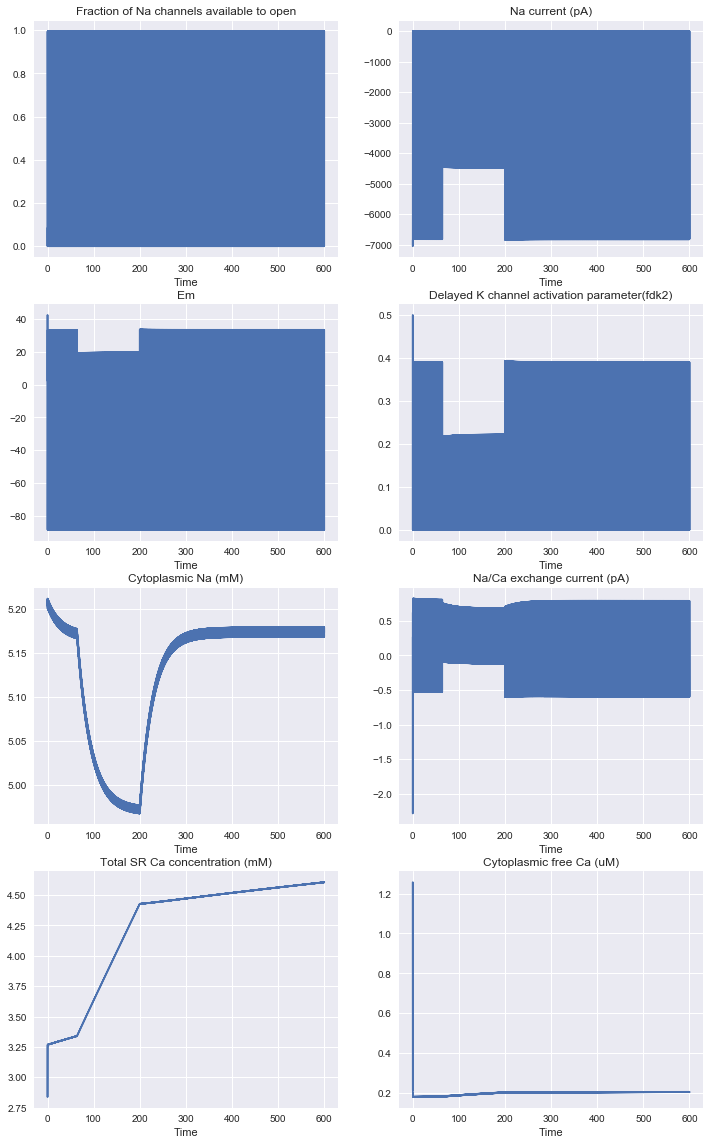

In [11]:
plt.figure(figsize = [12,20])

plt.subplot(4,2,1)
plt.plot(DF['tout'],DF['frout'])
plt.xlabel('Time')
plt.title('Fraction of Na channels available to open')

plt.subplot(4,2,2)
plt.plot(DF['tout'],DF['inaout'])
plt.xlabel('Time')
plt.title('Na current (pA)')

plt.subplot(4,2,3)
plt.plot(DF['tout'],DF['emout'])
plt.xlabel('Time')
#plt.xlim(0,1)
plt.title('Em')

plt.subplot(4,2,4)
plt.plot(DF['tout'],DF['fdknow'])
plt.xlabel('Time')
plt.title('Delayed K channel activation parameter(fdk2)')

plt.subplot(4,2,5)
plt.plot(DF['tout'],DF['ninow'])
plt.xlabel('Time')
plt.title('Cytoplasmic Na (mM)')

plt.subplot(4,2,6)
#plt.plot(DF['tout'],DF['icanow'])
plt.plot(DF['tout'],DF['incxnow'])
plt.xlabel('Time')
#plt.ylim([4.8,5.4])
plt.title('Na/Ca exchange current (pA)')

plt.subplot(4,2,7)
plt.plot(DF['tout'],DF['casrnow'])
plt.xlabel('Time')
plt.title('Total SR Ca concentration (mM)')

plt.subplot(4,2,8)
plt.plot(DF['tout'],DF['cinow']*1000)
plt.xlabel('Time')
plt.title('Cytoplasmic free Ca (uM)')

plt.savefig('plot_compact.png')
plt.show()

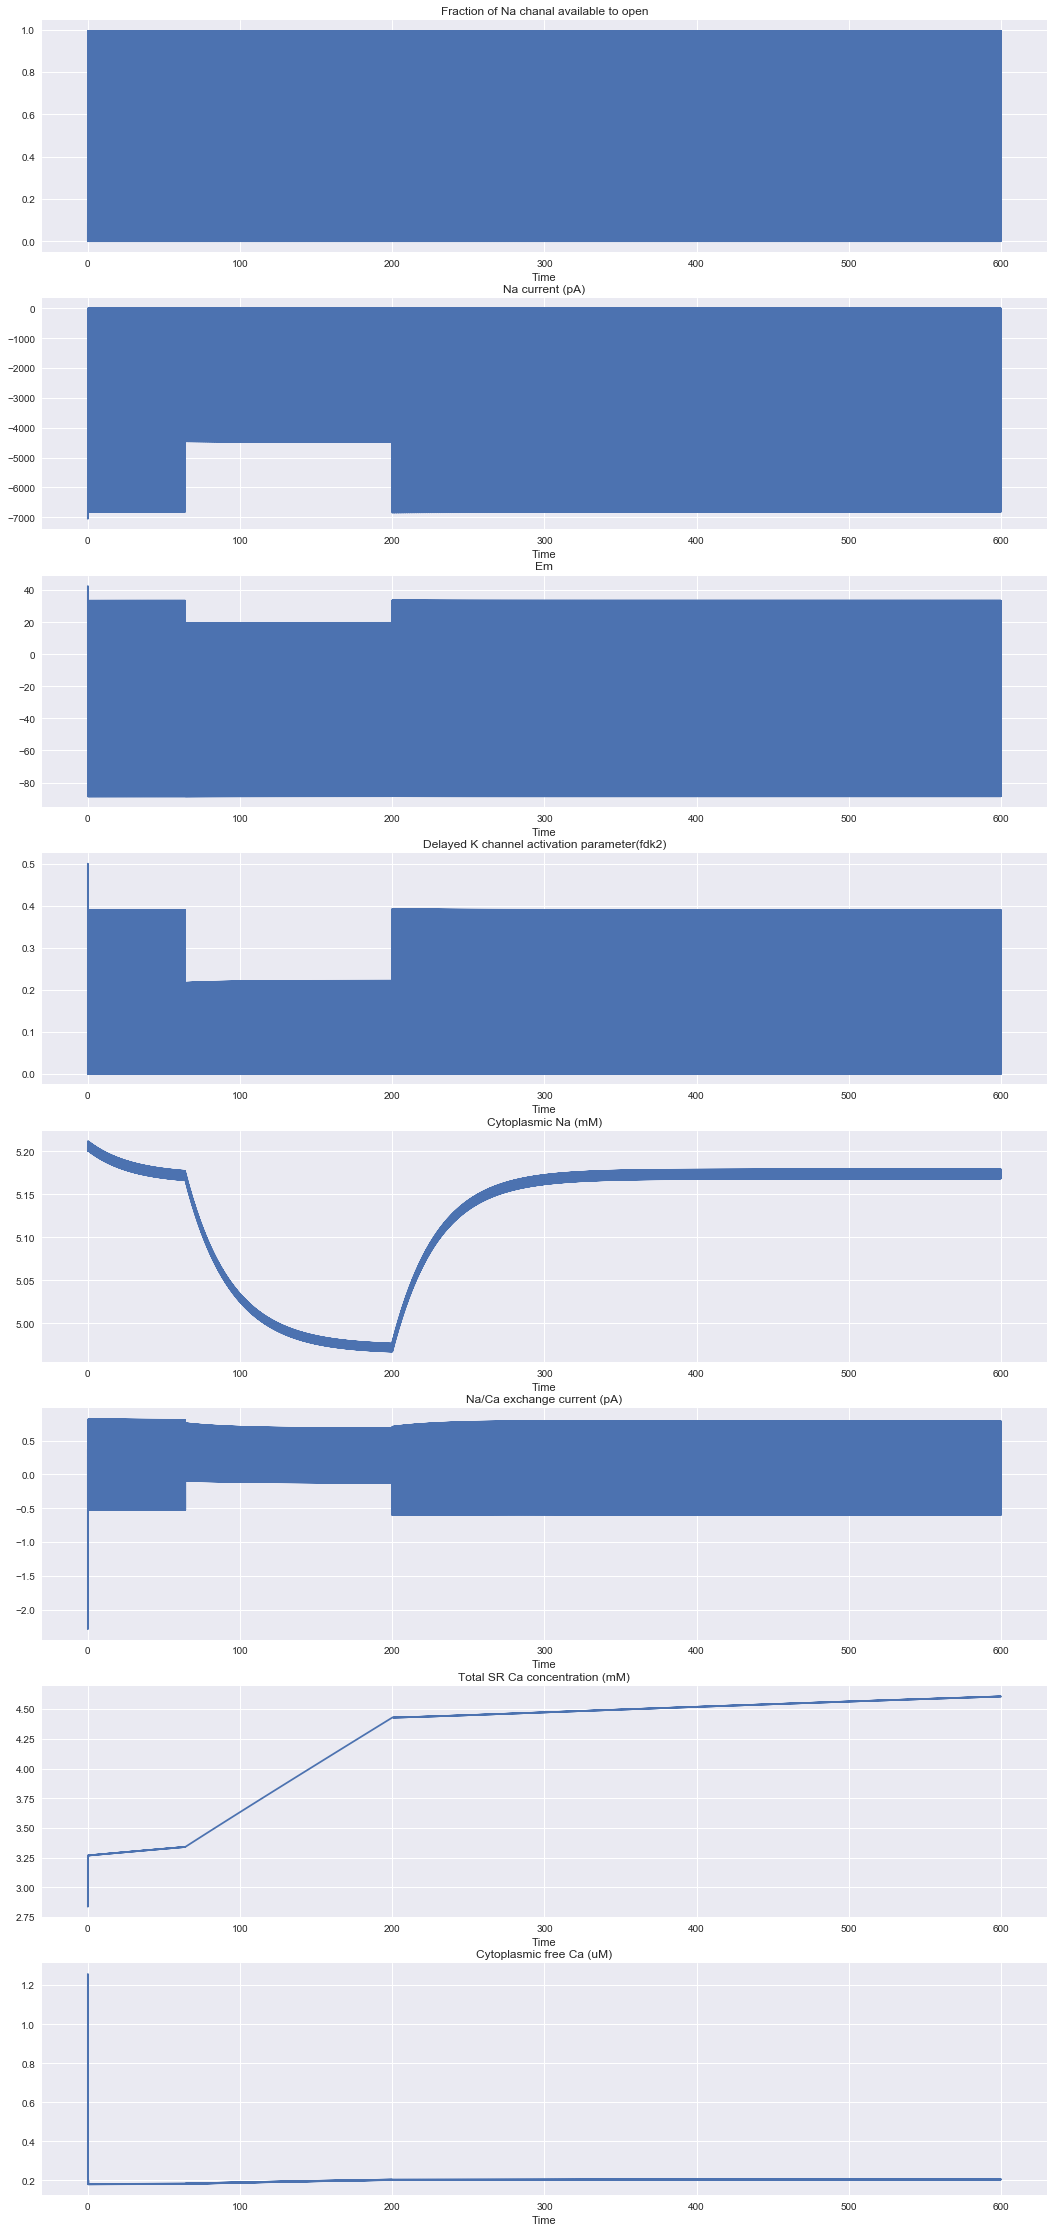

In [12]:
plt.figure(figsize = [18,40])

plt.subplot(8,1,1)
plt.plot(DF['tout'],DF['frout'])
plt.xlabel('Time')
plt.title('Fraction of Na chanal available to open')

plt.subplot(8,1,2)
plt.plot(DF['tout'],DF['inaout'])
plt.xlabel('Time')
plt.title('Na current (pA)')

plt.subplot(8,1,3)
plt.plot(DF['tout'],DF['emout'])
plt.xlabel('Time')
#plt.xlim(0,1)
plt.title('Em')

plt.subplot(8,1,4)
plt.plot(DF['tout'],DF['fdknow'])
plt.xlabel('Time')
plt.title('Delayed K channel activation parameter(fdk2)')

plt.subplot(8,1,5)
plt.plot(DF['tout'],DF['ninow'])
plt.xlabel('Time')
plt.title('Cytoplasmic Na (mM)')

plt.subplot(8,1,6)
#plt.plot(DF['tout'],DF['icanow'])
plt.plot(DF['tout'],DF['incxnow'])
plt.xlabel('Time')
#plt.ylim([4.8,5.4])
plt.title('Na/Ca exchange current (pA)')

plt.subplot(8,1,7)
plt.plot(DF['tout'],DF['casrnow'])
plt.xlabel('Time')
plt.title('Total SR Ca concentration (mM)')

plt.subplot(8,1,8)
plt.plot(DF['tout'],DF['cinow']*1000)
plt.xlabel('Time')
plt.title('Cytoplasmic free Ca (uM)')

plt.savefig('plot_flat.png')
plt.show()